## Créditos

O conteúdo deste notebook usa material das seguines fontes:

- [Deep Learning Wizard](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_logistic_regression/)

- [Deep Learning with PyTorch: Zero to GANs](https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans)

# Redes Multi-Layer Perceptron (MLP)

Uma rede MLP (Multi-layer Perceptron) é um tipo de rede neural artificial composta por várias camadas de neurônios (também chamados de unidades ou nós), organizadas em uma arquitetura feedforward. O MLP é um dos modelos mais básicos e fundamentais em aprendizado de máquina e é amplamente utilizado em tarefas de classificação e regressão.

Uma rede MLP consiste em três tipos principais de camadas:

- Camada de Entrada (Input Layer). Esta é a primeira camada da rede e recebe os dados de entrada. Cada neurônio nesta camada representa uma característica do vetor de entrada. A camada de entrada apenas distribui os dados para a próxima camada, sem realizar cálculos.

- Camadas Ocultas (Hidden Layers). Estas são as camadas intermediárias entre a camada de entrada e a camada de saída. Uma MLP pode ter uma ou mais camadas ocultas. Cada neurônio em uma camada oculta aplica uma transformação linear aos seus inputs (soma ponderada) seguida por uma função de ativação não linear (como ReLU, sigmoid, ou tanh). Essa não linearidade é o que permite que a rede MLP aprenda representações complexas dos dados.
A quantidade de neurônios em cada camada oculta e o número de camadas ocultas são hiperparâmetros que precisam ser ajustados de acordo com a tarefa específica.

- Camada de Saída (Output Layer). Esta é a última camada da rede e produz a saída final da MLP. O número de neurônios nesta camada depende da tarefa. Para classificação binária, geralmente há um único neurônio com uma função de ativação sigmoide. Para classificação multiclasse, o número de neurônios corresponde ao número de classes, e a função de ativação mais comum é softmax. Para regressão, pode haver um neurônio com uma ativação linear.

Este notebook aborda os seguintes tópicos:
 
 * Criação de uma rede neural MLP para classificação
 * Função de ativação
 * Uso de GPUs para acelerar o treinamento
 * Experimentos com hiperparâmetros para melhorar o modelo

# Criando um modelo MLP

Anteriormente, treinamos um modelo de classificação para identificar dígitos manuscritos do conjunto de dados MNIST com uma acurácia de cerca de 86%. O conjunto de dados consiste em imagens em tons de cinza de 28 x 28 pixels de dígitos manuscritos (0 a 9) e rótulos para cada imagem indicando qual dígito ela representa. Aqui estão alguns exemplos de imagens do conjunto de dados:

<center><img src='https://i.imgur.com/CAYnuo1.jpg'></center>

Percebemos que é bastante desafiador melhorar a acurácia daquele modelo além de 86%, uma vez que aquele modelo foi definido de tal forma a considerar que há uma **relação linear** entre intensidades de pixel e rótulos de imagem. De fato, mesmo que adicionassemos mais camadas `nn.Linear` ao modelo anterior, isso não faria com que esse modelo produzisse resultados melhores, porque a composição de funções lineares é também uma função linear.

Agora, vamos tentar criar um modelo melhor usando uma *rede neural feed-forward* que pode capturar relacionamentos não lineares entre entradas e alvos.

Vamos começar importando os módulos e classes necessários de `torch`,` torchvision`, `numpy` e `matplotlib`.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Podemos baixar os dados e criar um conjunto de dados PyTorch usando a classe `MNIST` fornecida no pacote `torchvision.datasets`.

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 8.99MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 246kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.24MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.89MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Vejamos algumas imagens do conjunto de dados. As imagens são convertidas em tensores PyTorch com a forma `1x28x28`. Essas dimensões representam, nesta ordem, o quantidade de canais de cores (igual a 1, pois as imagens são monocromáticas), a largura e a altura. 

Podemos usar `plt.imshow` para exibir as imagens. No entanto, a função `plt.imshow` espera que as imagens sejam estruturadas como (linhas, colunas) para imagens monocromáticas, e (linhas, colunas, canais) valores para imagens RGB. Sendo assim, temos que usar o método `reshape` para transformar os tensores de 3D para 2D.

image.shape: torch.Size([1, 28, 28])
Label: 5


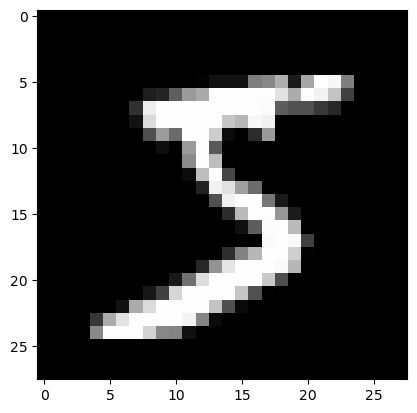

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.reshape(28, 28), cmap='gray')
print('Label:', label)

No código acima, em vez de usar `reshape`, podemos alternativamente usar a função [`squeeze`](https://pytorch.org/docs/main/generated/torch.squeeze.html). Veja o bloco de código a seguir.

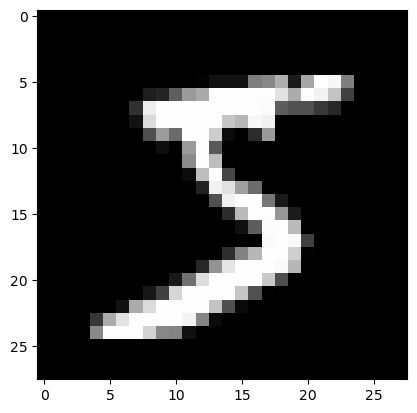

In [4]:
plt.imshow(image.squeeze(0), cmap='gray')

Uma terceira alternativa é usar o tensor `image[0]` como argumento na chamada de `plt.imgshow`.

Label: 5


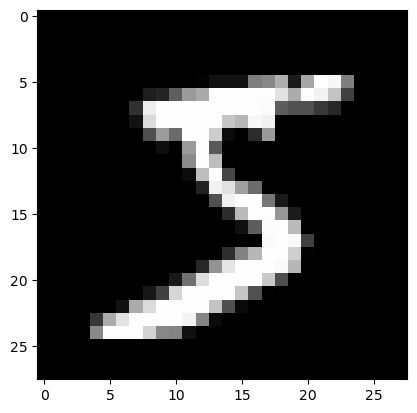

In [5]:
image, label = dataset[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

A seguir, vamos usar a função auxiliar `random_split` para separar 10.000 imagens para o [conjunto de validação](https://developers.google.com/machine-learning/crash-course/overfitting/dividing-datasets?hl=pt-br).

In [6]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

Agora podemos criar carregadores de dados PyTorch para serem usados durante o treinamento e validação do modelo de classificação.

Um parâmetro importante na criação de um carregador é o `tamanho do batch`. O treinamento de uma rede neural é normalmente feito usando gradiente descendente estocástico ([Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) - SGD) ou alguma de suas variantes. Como geralmente os datasets são muito grandes, o treinamento não é feito com todas as amostras de uma vez (gradiente descendente em lote) nem uma amostra por vez (gradiente descendente estocástico puro), mas sim em mini-lotes (mini-batch gradient descent).

In [7]:
batch_size = 128

Se `batch_size = 128`, significa que, a cada iteração do treinamento, a rede neural processará 128 amostras antes de calcular o gradiente e atualizar os pesos.

Esse valor é usado ao carregar os dados com um `DataLoader` em PyTorch:

In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

No bloco de código acima, são instanciados objetos das classes [DataLoader](https://pytorch.org/docs/stable/data.html).

`train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)`

- `train_ds`: the training dataset.

- `batch_size`: the number of samples per batch. Each iteration will yield a batch of this size from train_ds.

- `shuffle=True`: randomly shuffles the dataset at the beginning of each epoch, which is crucial for training to reduce bias and improve generalization.

- `num_workers=2`: two subprocesses are used to load the data in parallel, which can speed up data loading.

- `pin_memory=True`: if True, the DataLoader will copy tensors into CUDA pinned memory before returning them. This can speed up transfer of data to GPU.

`val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)`

- `val_ds`: the validation dataset.

- `batch_size*2`: validation batches are twice the size of training batches. This is a common practice when validation doesn't need backpropagation and thus uses less GPU memory.

- `shuffle` is not set: defaults to False, which is typical for validation to ensure reproducibility.

- Other parameters are the same as in the training loader.

Para fins de inspeção e análise exploratória, vamos visualizar um lote de exemplos em uma grade usando a função [`make_grid`](https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html) da biblioteca `torchvision`. Também usamos o método `.permute` no tensor para mover os canais para a última dimensão, porque essa é a ordem de dimensões esperada pela função [`imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) da biblioteca `matplotlib`.

images.shape: torch.Size([128, 1, 28, 28])
torch.Size([3, 242, 482])


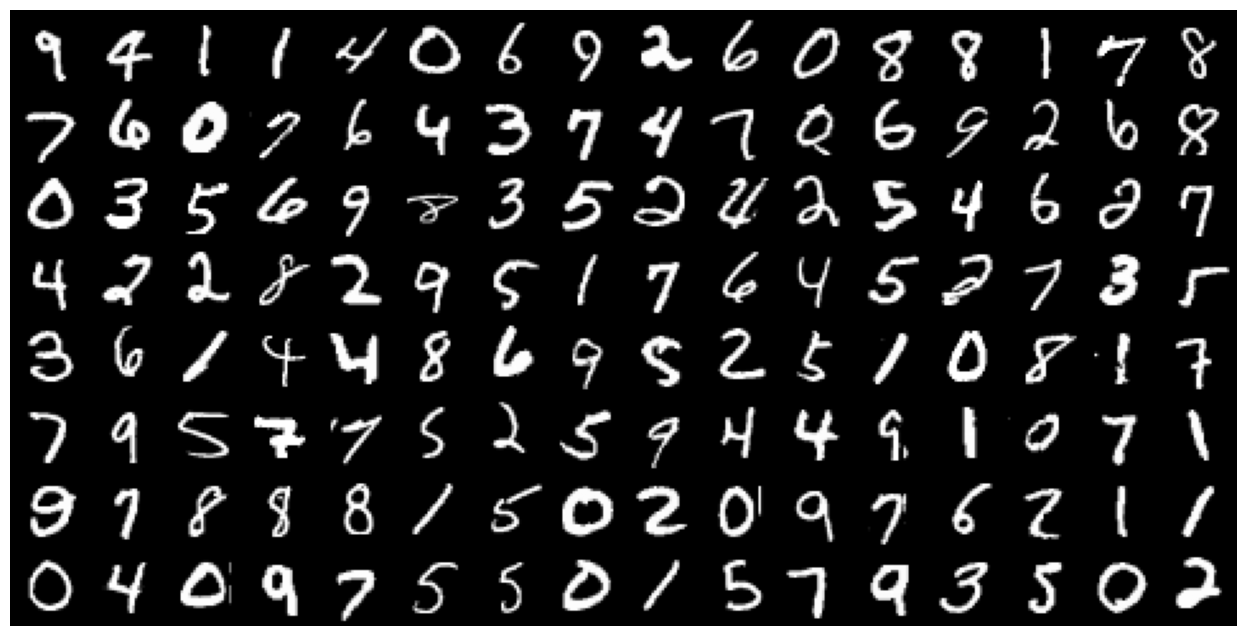

In [9]:
for images, _ in train_loader:
    # Prints the shape of the batch of images. The shape is typically (batch_size, channels, height, width).
    print('images.shape:', images.shape)

    # Creates a new figure for plotting, setting its size to 16x8 inches. 
    # plt.axis('off') removes the axes for a cleaner display.
    plt.figure(figsize=(16,8))
    plt.axis('off')

    # Uses torchvision.utils.make_grid to arrange a batch of images into a single image grid. 
    # The nrow=16 argument specifies that 16 images should be displayed per row.
    img_grid = make_grid(images, nrow=16)

    # Prints the shape of the resulting image grid. The shape is typically (channels, new_height, new_width).
    print(img_grid.shape)

    # Displays the image grid using Matplotlib. The tensor is permuted 
    # from (C, H, W) to (H, W, C) to match the expected format of imshow.
    plt.imshow(img_grid.permute((1, 2, 0)))

    # Stops the loop after displaying the first batch. This ensures that only one batch is visualized.
    break

# Camadas ocultas, funções de ativação e não linearidade

Vamos criar uma rede neural com duas camadas: uma _camada oculta_ e uma _camada de saída_. Além disso, usaremos uma _função de ativação_ entre as duas camadas. Vejamos um exemplo passo a passo para aprender como camadas ocultas e funções de ativação podem ajudar a capturar relacionamentos não lineares entre entradas e saídas.

Primeiro, vamos criar um lote de tensores de entrada. Vamos nivelar as imagens `1x28x28` em vetores 1D de tamanho `784` para que possam ser passadas para um objeto `nn.Linear`.

In [10]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


A seguir, vamos criar um objeto `nn.Linear`, que irá corresponder à camada _oculta_. Definiremos o tamanho da saída da camada oculta para 32. Esse número pode ser aumentado ou diminuído para alterar a _capacidade de aprendizado_ do modelo.

In [11]:
input_size = inputs.shape[-1]
hidden_size = 32

In [12]:
print(input_size)

784


In [13]:
layer1 = nn.Linear(input_size, hidden_size)

Agora podemos calcular saídas intermediárias para o lote de imagens, passando `inputs` através da `layer1`.

In [14]:
inputs.shape

torch.Size([128, 784])

In [15]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


Os vetores de imagem de tamanho `784` são transformados em vetores de saída intermediários de comprimento` 32` realizando uma multiplicação da matriz `inputs` com a matriz (trasposta) de pesos `layer1` e adicionando o viés. Podemos verificar isso usando `torch.allclose`.

In [16]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [17]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Repare que `layer1_outputs` e `inputs` têm uma relação linear, ou seja, cada elemento de `layer_outputs` é uma soma ponderada de elementos de `entradas`. Assim, mesmo enquanto treinamos o modelo e modificamos os pesos, `layer1` só pode capturar relações lineares entre `entradas` e `saídas`.

<p align="center">
<img src="https://i.imgur.com/inXsLuq.png" width="360">
</p>

A seguir, usaremos a função de Unidade Linear Retificada (Rectified Linear Unit, [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))) como a função de ativação para as saídas. Essa função computa a expressão matemática abaixo:
> `relu(x) = max(0, x)` 

Essa função simplesmente substitui os valores negativos em um determinado tensor pelo valor 0. ReLU é uma função não linear, como visto aqui:

<p align="center">
<img src="https://i.imgur.com/yijV4xF.png" width="420">
</p>

Podemos usar o métoto `F.relu` para aplicar ReLU aos elementos de um tensor.

In [18]:
F.relu(torch.tensor([[1,    -1,  0], 
                     [-0.1, .2,  3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Vamos aplicar a função de ativação a `layer1_outputs` e verificar se os valores negativos foram substituídos por 0.

In [19]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.5868634581565857
min(relu_outputs): 0.0


Agora que aplicamos uma função de ativação não linear, `relu_outputs` e `inputs` não têm uma relação linear. Nos referimos a `ReLU` como a _função de ativação_, porque para cada entrada certas saídas são ativadas (aquelas com valores diferentes de zero) enquanto outras desligadas (aquelas com valores zero)

A seguir, vamos criar uma camada de saída para converter vetores de comprimento `hidden_size` em `relu_outputs` em vetores de comprimento 10, que é a saída desejada de nosso modelo (já que existem 10 classes).

In [20]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [21]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [22]:
inputs.shape

torch.Size([128, 784])

Como esperado, `layer2_outputs` contém um lote de vetores de tamanho 10. Podemos agora usar esta saída para calcular a função de custo usando `F.cross_entropy` e ajustar os pesos de `layer1` e de `layer2` usando o algoritmo gradiente descendente.

In [23]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2969, grad_fn=<NllLossBackward0>)

Assim, nosso modelo transforma `inputs` em `layer2_outputs` aplicando uma transformação linear (usando `layer1`), seguida por uma ativação não linear (usando `F.relu`), seguida por outra transformação linear (usando `layer2`) Vamos verificar isso recalculando a saída usando operações matriciais básicas.

In [24]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [25]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Observe que `outputs` e `inputs` não têm uma relação linear devido à função de ativação não linear `F.relu`. À medida que treinamos o modelo e ajustamos os pesos de `layer1` e de `layer2`, podemos agora capturar relações não lineares entre as imagens e seus rótulos. Em outras palavras, a introdução da não linearidade torna o modelo mais poderoso e versátil. Além disso, como `hidden_size` não depende das dimensões das entradas ou saídas, nós o variamos para aumentar o número de parâmetros dentro do modelo. Também podemos introduzir novas camadas ocultas e aplicar a mesma ativação não linear após cada camada oculta.

O modelo que acabamos de criar é chamado de rede neural. Uma _rede neural profunda_ é simplesmente uma rede neural com uma ou mais camadas ocultas. 

O [Teorema de Aproximação Universal](http://neuralnetworksanddeeplearning.com/chap4.html) afirma que uma rede neural de apenas uma camada e com uma quantidade neurônios suficientemente grande é capaz de computar qualquer função arbitrária, ou seja, pode _aprender_ relações não lineares complexas entre entradas e alvos. Aqui estão alguns exemplos:

* Identificar se uma imagem contém um gato ou um cachorro (ou [outra coisa](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/));
* Identificar o gênero de uma música usando uma amostra de 10 segundos;
* Classificar resenhas de filmes como positivas ou negativas com base em seu conteúdo;
* Navegar em carros autônomos usando um feed de vídeo da estrada;
* Tradução de frases do inglês para o francês (e centenas de outras línguas);
* Converter uma gravação de fala em texto e vice-versa
* E muitos mais...

É difícil imaginar como o processo simples de multiplicar entradas com matrizes inicializadas aleatoriamente, aplicar ativações não lineares e ajustar pesos repetidamente usando gradiente descendente pode produzir resultados surpreendentes. Modelos de aprendizado profundo geralmente contêm milhões de parâmetros, que juntos podem capturar relacionamentos muito mais complexos do que o cérebro humano pode compreender.

Se não tivéssemos incluído uma ativação não linear entre as duas camadas lineares, a relação final entre entradas e saídas ainda seria linear. Uma simples refatoração dos cálculos ilustra isso.

In [26]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [27]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [28]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [29]:
torch.allclose(outputs2, outputs3, 1e-3)

True

# Ajuste do Modelo

Agora estamos prontos para definir nosso modelo. Conforme discutido acima, criaremos uma rede neural com uma camada oculta. Aqui está o que isso significa:

* Em vez de usar um único objeto `nn.Linear` para transformar um lote de entradas (intensidades de pixel) em saídas (probabilidades de classe), usaremos dois objetos `nn.Linear`. Cada um deles é chamado de _camada_ na rede.

* A primeira camada (também conhecida como camada oculta) transformará a matriz de entrada da forma `batch_size x 784` em uma matriz de saída intermediária da forma `batch_size x hidden_size`. O parâmetro `hidden_size` pode ser configurado manualmente (por exemplo, 32 ou 64).

* Aplicamos então uma *função de ativação* não linear às saídas intermediárias. A função de ativação transforma elementos individuais da matriz.

* O resultado da função de ativação, que também tem o tamanho `batch_size x hidden_size`, é passado para a segunda camada (também conhecida como camada de saída). A segunda camada o transforma em uma matriz de tamanho `batch_size x 10`. Podemos usar essa saída para calcular a perda e ajustar os pesos usando gradiente descendente.


Conforme discutido acima, nosso modelo conterá uma camada oculta. Aqui está o que parece visualmente:

<p align="center">
<img src="https://i.imgur.com/eN7FrpF.png" width="480">
</p>

Vamos definir o modelo estendendo a classe `nn.Module` do PyTorch.



In [30]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

Também precisamos definir uma função denominada `accuracy` que calcula a acurácia da previsão do modelo em um lote de entradas. Essa função é usada em `validation_step` acima.

In [31]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Vamos criar um modelo que contém uma camada oculta com 32 unidades.

In [32]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [33]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

Vamos dar uma olhada nos parâmetros do modelo. Esperamos ver uma matriz de pesos e outras de viés para cada uma das camadas.

In [34]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Vamos tentar gerar algumas saídas usando nosso modelo. Vamos pegar o primeiro lote de 128 imagens de nosso conjunto de dados e passá-las para nosso modelo.

In [35]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.313594341278076
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1603,  0.2552,  0.0077,  0.1887, -0.0762, -0.1551, -0.0552, -0.1381,
          0.0726, -0.0576],
        [ 0.1740,  0.2216, -0.0238,  0.1588, -0.0613, -0.1348,  0.0035, -0.2112,
          0.0884, -0.0365]])


## Usando uma GPU

Conforme os tamanhos de nossos modelos e conjuntos de dados aumentam, é recomendável usar uma ou mais [Unidades de Processamento Gráfico](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU). Uma GPU contém centenas de núcleos otimizados para realizar operações matriciais dispendiosas em números de ponto flutuante rapidamente, tornando-as ideais para o treinamento de redes neurais profundas. Você pode usar GPUs gratuitamente nas plataformas [Google Colab](https://colab.research.google.com/) e [Kaggle](https://www.kaggle.com/kernels). Você também pode alugar máquinas com GPU em serviços como [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), e [Paperspace](https://www.paperspace.com/).

> No _Google Colab_, use a opção de menu "Runtime> Change Runtime Type" e selecione "GPU" no menu suspenso "Hardware Accelerator".

Podemos verificar se uma GPU está disponível e se os drivers NVIDIA CUDA necessários estão instalados usando `torch.cuda.is_available`.

In [36]:
import torch 
torch.cuda.is_available()

False

Podemos também verificar a quantidade de GPUs disponíveis por meio da função `torch.cuda.device_count()`.

In [37]:
torch.cuda.device_count()

0

Vamos definir uma função auxiliar para garantir que nosso código use uma GPU, se disponível, e o padrão para usar a CPU se não estiver.

In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [39]:
device = get_default_device()
device

device(type='cpu')

A seguir, vamos definir uma função que pode mover dados e modelo para um dispositivo escolhido.

In [40]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [41]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


Finalmente, definimos uma classe `DeviceDataLoader` para empacotar nossos carregadores de dados existentes e mover lotes de dados para o dispositivo selecionado. Curiosamente, não precisamos estender uma classe existente para criar um DataLoader do PyTorch. Tudo o que precisamos é um método `__iter__` para recuperar lotes de dados e um método `__len__` para obter o número de lotes.

In [42]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

A palavra-chave `yield` em Python é usada para criar uma função geradora (*generator function*) que pode ser usada dentro de um loop `for`, conforme ilustrado abaixo.

In [43]:
def some_numbers():
    yield 10
    print('teste1')
    yield 20
    print('teste2')
    yield 30
    print('teste3')

for value in some_numbers():
    print(value)
    print('***')

10
***
teste1
20
***
teste2
30
***
teste3


Agora podemos encapsular nossos carregadores de dados usando `DeviceDataLoader`.

In [44]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Os tensores movidos para a GPU têm uma propriedade `device` que inclui a palavra `cuda`. Vamos verificar isso olhando um lote de dados de `valid_dl`.

In [45]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([1, 6, 0, 0, 5, 2, 3, 3, 8, 4, 8, 4, 0, 5, 3, 9, 7, 8, 6, 6, 1, 8, 1, 8,
        0, 9, 9, 6, 7, 2, 6, 6, 4, 4, 8, 3, 5, 8, 6, 3, 5, 2, 5, 1, 2, 0, 0, 6,
        7, 6, 4, 3, 8, 5, 8, 3, 3, 8, 1, 1, 8, 6, 4, 5, 5, 6, 3, 6, 8, 7, 5, 7,
        1, 6, 5, 5, 2, 5, 8, 4, 3, 1, 8, 6, 0, 6, 4, 5, 2, 2, 6, 7, 4, 6, 2, 4,
        6, 9, 7, 7, 4, 6, 8, 2, 4, 9, 5, 8, 8, 1, 8, 0, 3, 3, 3, 7, 0, 1, 2, 9,
        6, 5, 5, 1, 7, 2, 9, 2, 1, 3, 2, 5, 5, 2, 9, 3, 0, 2, 2, 4, 6, 2, 4, 2,
        7, 9, 2, 6, 5, 0, 8, 2, 6, 7, 6, 9, 1, 1, 1, 8, 5, 5, 7, 8, 5, 2, 9, 0,
        6, 8, 1, 9, 8, 9, 0, 1, 6, 3, 9, 8, 7, 7, 3, 4, 0, 6, 6, 9, 2, 4, 2, 4,
        7, 5, 3, 6, 2, 8, 4, 8, 6, 4, 6, 5, 1, 5, 2, 5, 6, 2, 7, 2, 8, 1, 0, 3,
        7, 4, 1, 0, 7, 1, 9, 8, 7, 5, 7, 2, 2, 9, 8, 1, 0, 1, 9, 0, 0, 7, 9, 6,
        4, 1, 3, 4, 7, 9, 4, 7, 0, 3, 0, 4, 1, 8, 0, 0])


## Treinando o modelo

Vamos definir duas funções: `fit` e `evaluate` para treinar o modelo usando gradiente descendente e avaliar seu desempenho sobre o conjunto de validação.

In [46]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss.detach())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        model.eval()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


Antes de treinarmos o modelo, precisamos garantir que os dados e os parâmetros do modelo (pesos e vieses) estejam no mesmo dispositivo (CPU ou GPU). Podemos reutilizar a função `to_device` para mover os parâmetros do modelo para o dispositivo certo.

In [47]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Vamos ver o desempenho preditivo do modelo no conjunto de validação com o conjunto inicial de pesos e vieses.

In [48]:
initial_result = evaluate(model, val_loader)
initial_result['train_loss'] = np.nan
history = [initial_result]
history


[{'val_loss': 2.318948268890381,
  'val_acc': 0.07353515923023224,
  'train_loss': nan}]

A acurácia inicial é de cerca de 10%, como se poderia esperar de um modelo inicializado aleatoriamente (uma vez que há 1 chance em 10 de acertar um rótulo por acaso).

Vamos treinar o modelo por cinco épocas e ver os resultados. Podemos usar uma taxa de aprendizado relativamente alta de $0.5$.

In [49]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2225, val_acc: 0.9317
Epoch [1], val_loss: 0.1785, val_acc: 0.9447
Epoch [2], val_loss: 0.1672, val_acc: 0.9481
Epoch [3], val_loss: 0.1444, val_acc: 0.9544
Epoch [4], val_loss: 0.1483, val_acc: 0.9546


A acurácia obtida é aproximadamente 96%, o que corresponde a uma melhoria significativa quando comparamos com os 86% de acurácia do modelo treinado sem camada oculta e sem função de ativação.

Vamos treinar o modelo por mais cinco épocas, desta vez usando uma taxa de aprendizado menor.

In [50]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1235, val_acc: 0.9614
Epoch [1], val_loss: 0.1224, val_acc: 0.9623
Epoch [2], val_loss: 0.1199, val_acc: 0.9641
Epoch [3], val_loss: 0.1191, val_acc: 0.9635
Epoch [4], val_loss: 0.1217, val_acc: 0.9634


Ao que parece, atingimos um novo limite superior (próximo de 96%) para a acurácia do modelo treinado com a nova arquitetura.

Agora podemos representar graficamente os custos e acurácias para estudar como o modelo melhora ao longo do treinamento.

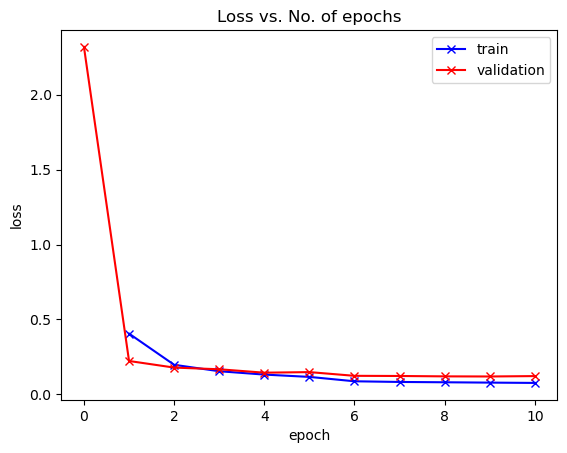

In [51]:
train_losses = [x['train_loss'] for x in history]
val_losses = [x['val_loss'] for x in history]

plt.plot(train_losses, '-bx', label='train')
plt.plot(val_losses, '-rx', label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')
plt.legend();


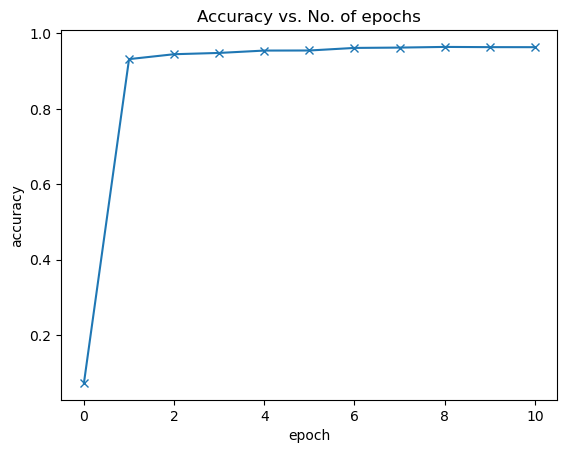

In [52]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Nosso modelo atual supera o modelo de regressão logística (que só conseguiu atingir cerca de 86% de acurácia) por uma margem considerável! Ele atinge rapidamente uma acurácia próxima de 97%, mas não melhora muito além disso. Para melhorar ainda mais a acurácia, precisamos tornar o modelo mais poderoso aumentando o tamanho da camada oculta ou adicionando mais camadas ocultas com ativações. Eu o encorajo a experimentar ambas as abordagens e ver qual funciona melhor.

## Testando com imagens individuais

Embora tenhamos rastreado a acurácia geral de um modelo até agora, também é uma boa ideia olhar os resultados do modelo em algumas imagens de amostra. Vamos testar nosso modelo com algumas imagens do conjunto de dados de teste predefinido de 10.000 imagens. Começamos recriando o conjunto de dados de teste com a transformação `ToTensor`.

In [53]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

Vamos definir uma função auxiliar `Predict_image`, que retorna o rótulo previsto para um único tensor de imagem.

In [54]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Vamos experimentar com algumas imagens.

Label: 7 , Predicted: 7


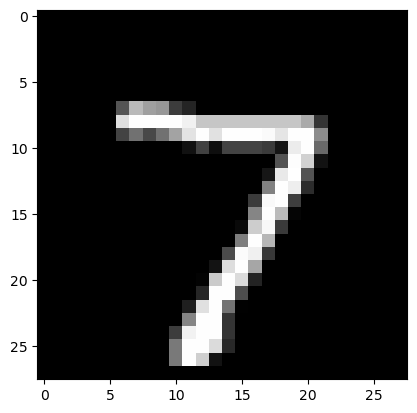

In [55]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


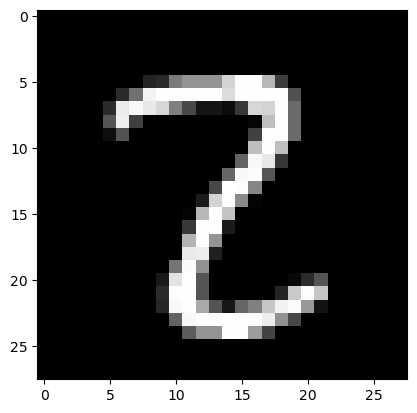

In [56]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


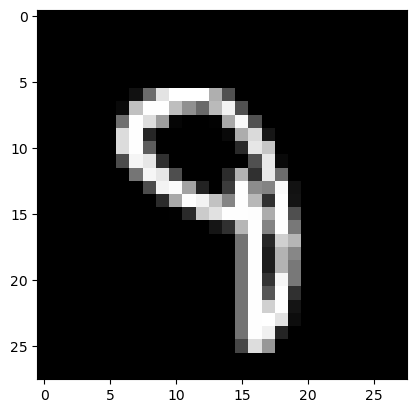

In [57]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identificar onde nosso modelo tem um desempenho insatisfatório pode nos ajudar a melhorá-lo, coletando mais dados de treinamento, aumentando/diminuindo a complexidade do modelo e alterando os hipeparâmetros.

Como uma etapa final, vamos também examinar os valores médios da função de custo e a acurácia do modelo sobre o conjunto de teste.

In [58]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.11408787965774536, 'val_acc': 0.966015636920929}

Conforme esperado, o desempenho preditivo sobre o conjunto de teste é semelhante ao obtido sobre o conjunto de validação. Se isso não se verificar, talvez precisemos de um conjunto de validação melhor que tenha dados e distribuição semelhantes ao conjunto de teste (que geralmente vem de dados do mundo real).

## Matriz de confusão no conjunto de teste

A matriz de confusão abaixo resume os acertos e erros por classe (`0` a `9`) no conjunto de teste.


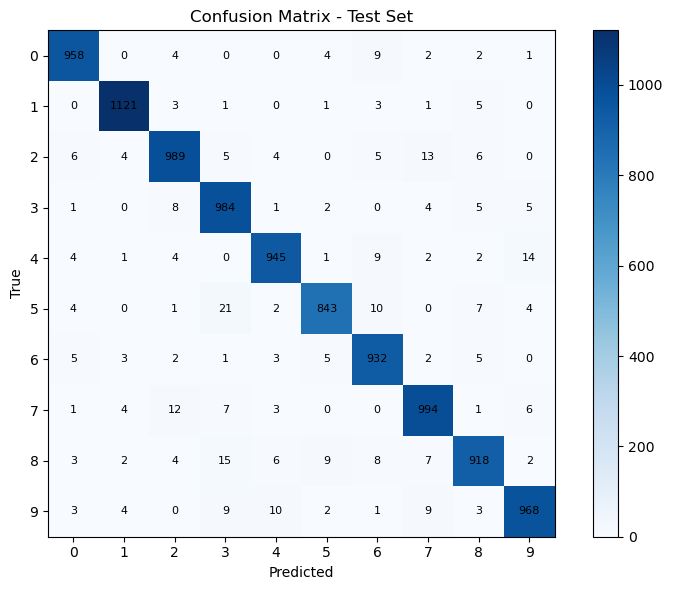

tensor([[ 958,    0,    4,    0,    0,    4,    9,    2,    2,    1],
        [   0, 1121,    3,    1,    0,    1,    3,    1,    5,    0],
        [   6,    4,  989,    5,    4,    0,    5,   13,    6,    0],
        [   1,    0,    8,  984,    1,    2,    0,    4,    5,    5],
        [   4,    1,    4,    0,  945,    1,    9,    2,    2,   14],
        [   4,    0,    1,   21,    2,  843,   10,    0,    7,    4],
        [   5,    3,    2,    1,    3,    5,  932,    2,    5,    0],
        [   1,    4,   12,    7,    3,    0,    0,  994,    1,    6],
        [   3,    2,    4,   15,    6,    9,    8,    7,  918,    2],
        [   3,    4,    0,    9,   10,    2,    1,    9,    3,  968]])

In [59]:
conf_matrix = torch.zeros(10, 10, dtype=torch.int64)

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        _, preds = torch.max(outputs, dim=1)
        for t, p in zip(yb.view(-1), preds.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix.cpu().numpy(), cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(10))
plt.yticks(range(10))
plt.colorbar()

for i in range(10):
    for j in range(10):
        value = conf_matrix[i, j].item()
        plt.text(j, i, str(value), ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()
conf_matrix


# Resumo e leituras adicionais

Aqui está um resumo dos tópicos abordados neste tutorial:

* Criamos uma rede neural MLP com uma camada oculta para aprimorar o modelo de classificação do tutorial anterior. Também usamos a função de ativação ReLU para introduzir a não linearidade no modelo, permitindo que ele aprendesse relações mais complexas entre as entradas (densidades de pixel) e as saídas (probabilidades de classe).

* Definimos alguns utilitários como `get_default_device`,` to_device` e `DeviceDataLoader` para alavancar uma GPU se disponível, movendo os dados de entrada e parâmetros de modelo para o dispositivo apropriado.

* Fomos capazes de usar exatamente o mesmo loop de treinamento: a função `fit` que definimos anteriormente para treinar o modelo e avaliá-lo usando o conjunto de dados de validação.

Há muito escopo para experimentar aqui, e eu encorajo você a usar a natureza interativa do Jupyter para brincar com os vários parâmetros. Aqui estão algumas idéias:

* Tente alterar o tamanho da camada oculta ou adicione mais camadas ocultas e veja se consegue obter uma acurácia maior.

* Experimente alterar o tamanho do lote e a taxa de aprendizagem para ver se consegue obter a mesma acurácia em menos épocas.

* Compare os tempos de treinamento em uma CPU e GPU. Você vê uma diferença significativa. Como isso varia com o tamanho do conjunto de dados e o tamanho do modelo (número de pesos e parâmetros)?

* Tente construir um modelo para um conjunto de dados diferente, como os [conjuntos de dados CIFAR10 ou CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html).

Aqui estão algumas referências para leituras adicionais:

1. [Uma animação para obter a intuição de que as redes neurais podem computar qualquer função](http://neuralnetworksanddeeplearning.com/chap4.html), também conhecido como Teorema de Aproximação Universal.

2. [Mas o que *é* uma rede neural?](https://www.youtube.com/watch?v=aircAruvnKk) - Uma introdução visual e intuitiva ao que são as redes neurais e o que as camadas intermediárias representam

3. [Stanford CS229 Lecture notes on Backpropagation](http://cs229.stanford.edu/notes/cs229-notes-backprop.pdf) - para um tratamento mais matemático de como os gradientes são calculados e os pesos são atualizados para redes neurais com múltiplos camadas.

4. [AI by Hand - Multi-Layer Perceptron](https://www.linkedin.com/posts/tom-yeh_mlp-neuralnetwork-aibyhand-activity-7246281602853453824-sTfB)